# Facial Emotion Recognition: 3/3

## Preliminary stuff

In [ ]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Importing Deep Learning Libraries

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, LeakyReLU, Attention, AlphaDropout
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Nadam, experimental, Adamax
# !pip install -q -U tensorflow_addons
# import tensorflow_addons as tfa
#from tensorflow_addons.optimizers import CyclicalLearningRate

In [ ]:
def metrics_score(actual, predicted):

    from sklearn.metrics import classification_report

    from sklearn.metrics import confusion_matrix

    print(classification_report(actual, predicted))

    cm = confusion_matrix(actual, predicted)

    plt.figure(figsize = (8, 5))

    sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['happy', 'neutral/sad', 'surprise'], yticklabels = ['happy', 'neutral/sad', 'surprise'])

    plt.ylabel('Actual')

    plt.xlabel('Predicted')

    plt.show()

In [ ]:
def metrics_score_binary(actual, predicted):

    from sklearn.metrics import classification_report

    from sklearn.metrics import confusion_matrix

    print(classification_report(actual, predicted))

    cm = confusion_matrix(actual, predicted)

    plt.figure(figsize = (8, 5))

    sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['sad', 'neutral'], yticklabels = ['sad', 'neutral'])

    plt.ylabel('Actual')

    plt.xlabel('Predicted')

    plt.show()

In [ ]:
# Storing the path of the data file from the Google drive
path = '/content/drive/MyDrive/binary.zip'

# The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
picture_size = 48
folder_path = "binary/"

## Data augmentation

This took some tuning but overall I feel good about the data having been futzed with enough so that it'll be pretty generalizable.

In [ ]:
data_aug = ImageDataGenerator(
                              rotation_range=15, # I don't think we need to care about upside down faces
                              width_shift_range=0.1, 
                              height_shift_range=0.1,
                              horizontal_flip=True,
                              fill_mode='constant', # don't want to introduce new confusing pixels
                              cval = 255 / 2,
                              brightness_range=[0.9,1.2],
                              rescale=1./255
                              )


img_size = 48

train_set_augmented = data_aug.flow_from_directory(folder_path + "train",
                                              target_size = (img_size, img_size),
                                              color_mode = 'grayscale' ,
                                              class_mode = 'categorical',
                                              shuffle = True)
validation_set_augmented = data_aug.flow_from_directory(folder_path + "validation",
                                              target_size = (img_size, img_size),
                                              color_mode = 'grayscale' ,
                                              class_mode = 'categorical',
                                              shuffle = True)

Found 15109 images belonging to 3 classes.
Found 4977 images belonging to 3 classes.


The following is for the non messed up images that I'll later try to train the binary classifier on.

In [ ]:
data_flow = ImageDataGenerator(#rescale=1./255
                               )
train_set = data_flow.flow_from_directory(folder_path + "train",
                                              target_size = (img_size, img_size),
                                              color_mode = 'grayscale' ,
                                              class_mode = 'categorical',
                                              shuffle = True)
validation_set = data_flow.flow_from_directory(folder_path + "validation",
                                              target_size = (img_size, img_size),
                                              color_mode = 'grayscale' ,
                                              class_mode = 'categorical',
                                              shuffle = True)

NameError: ignored

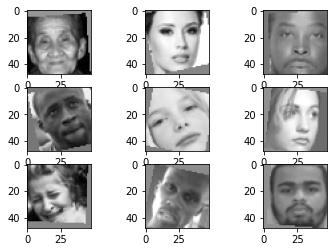

In [ ]:
import matplotlib.pyplot as plt

X, y = train_set_augmented.next()

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X[i].squeeze(), cmap='gray', vmin=0, vmax=1)

plt.show()


In [ ]:
no_of_classes = 2

In [ ]:
import keras
from keras import backend
model_3_128 = keras.models.load_model("/content/drive/MyDrive/model_3_128.h5")
#pd.read_csv("/content/drive/MyDrive/final history_10.csv")

## Binary Classification

Lets reload the model from last time, add a couple conv layers and some dense layers.

In [ ]:
from keras import layers
from keras.layers import *
binary_model = Sequential()

for i in range(0,11):
  binary_model.add(model_3_128.layers[i])
  binary_model.layers[i].set_weights(model_3_128.layers[i].get_weights())
  #binary_model.layers[i].trainable = False
binary_model.add(Conv2D(activation = 'relu', filters = 2048, kernel_size = 5, padding = 'same', name = 'bob'))
binary_model.add(MaxPool2D(padding = 'same', name = "i"))
binary_model.add(Conv2D(activation = 'relu', filters = 4096, kernel_size = 5, padding = 'same', name = 'bb'))
binary_model.add(MaxPool2D(padding = 'same', name = "j"))
binary_model.add(Flatten())

In [ ]:
for i in range(0,5):
  binary_model.add(Dense(128, 
                         activation = 'relu', 
                         kernel_initializer="he_normal"
                         ))
  #binary_model.add(Dropout(0.25))
binary_model.add(Dense(2,activation = 'sigmoid'))

In [ ]:
binary_model.compile(loss="binary_crossentropy", optimizer='adamax',metrics=[keras.metrics.AUC(multi_label=True,
    num_labels=2), "accuracy"])

In [ ]:
binary_model.fit(train_set, epochs=2, use_multiprocessing=True,
                     validation_data=validation_set)

Epoch 1/2
249/249 [==============================] - 16s 61ms/step - loss: 10524.1611 - auc_13: 0.5120 - accuracy: 0.5121 - val_loss: 50173.1719 - val_auc_13: 0.5000 - val_accuracy: 0.4837
Epoch 2/2
249/249 [==============================] - 13s 51ms/step - loss: 14659.4170 - auc_13: 0.5101 - accuracy: 0.5101 - val_loss: 67.0297 - val_auc_13: 0.5391 - val_accuracy: 0.5321


Right off the bat, not looking so, so, so outrageous.

In [ ]:
from keras import callbacks, metrics

callbacks = [callbacks.TerminateOnNaN(),
             callbacks.ModelCheckpoint('best_model.h5', 
                                       monitor = 'val_loss',
                                       verbose= 1,
                                       save_best_only = True),
             callbacks.EarlyStopping(min_delta=0.001, 
                                     patience = 5,
                                     verbose = 1,
                                     restore_best_weights = True)
             ]
binary_model.compile(loss=keras.losses.BinaryFocalCrossentropy(), optimizer='adamax',
                  metrics=[keras.metrics.AUC(multi_label = True, num_labels = 2), 'accuracy'])
binary_model.fit(train_set, 
                 epochs=100, 
                 use_multiprocessing=True,
                 validation_data=validation_set,
                 callbacks = callbacks)

I've omitted the output for brevity's sake but I can just say it wasn't pretty.

2/2 [==============================] - 1s 539ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        32
           1       0.00      0.00      0.00        32

    accuracy                           0.50        64
   macro avg       0.25      0.50      0.33        64
weighted avg       0.25      0.50      0.33        64



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


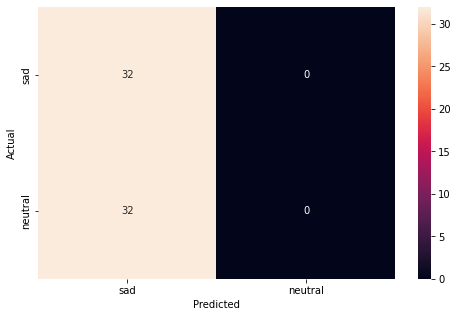

In [ ]:
datagen_test = ImageDataGenerator(rescale=1./255)

test_set = datagen_test.flow_from_directory(folder_path + "test",
                                                              target_size = (img_size,img_size),
                                                              color_mode = 'grayscale',
                                                              class_mode = 'categorical',
                                                              classes = ['sad', 'neutral'],
                                                              batch_size = 128,
                                                              shuffle = True) 
test_images, test_labels = next(test_set)
pred = binary_model.predict(test_images)
pred = np.argmax(pred, axis = 1) 
y_true = np.argmax(test_labels, axis = 1)
metrics_score_binary(y_true, pred)

In [ ]:

from sklearn.datasets import make_classification
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# no skill model, stratified random class predictions
model = DummyClassifier(strategy='stratified')
model.fit(trainX, trainy)
yhat = model.predict_proba(testX)
pos_probs = yhat[:, 1]
# calculate roc auc
roc_auc = roc_auc_score(testy, pos_probs)
print('No Skill ROC AUC %.3f' % roc_auc)
# skilled model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
yhat = model.predict_proba(testX)
pos_probs = yhat[:, 1]
# calculate roc auc
roc_auc = roc_auc_score(testy, pos_probs)
print('Logistic ROC AUC %.3f' % roc_auc)

No Skill ROC AUC 0.482
Logistic ROC AUC 0.903


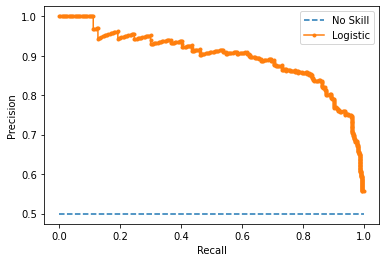

In [ ]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
yhat = model.predict_proba(testX)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# calculate the no skill line as the proportion of the positive class
no_skill = len(y[y==1]) / len(y)
# plot the no skill precision-recall curve
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(testy, pos_probs)
# plot the model precision-recall curve
pyplot.plot(recall, precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
precision, recall, _ = precision_recall_curve(testy, pos_probs)

In [ ]:
recall

array([1.        , 0.99615385, 0.99615385, 0.99615385, 0.99615385,
       0.99615385, 0.99615385, 0.99615385, 0.99615385, 0.99615385,
       0.99615385, 0.99615385, 0.99615385, 0.99615385, 0.99615385,
       0.99615385, 0.99615385, 0.99615385, 0.99615385, 0.99615385,
       0.99615385, 0.99615385, 0.99615385, 0.99615385, 0.99615385,
       0.99615385, 0.99615385, 0.99615385, 0.99615385, 0.99615385,
       0.99615385, 0.99230769, 0.99230769, 0.99230769, 0.99230769,
       0.99230769, 0.99230769, 0.99230769, 0.99230769, 0.99230769,
       0.99230769, 0.99230769, 0.98846154, 0.98846154, 0.98846154,
       0.98846154, 0.98846154, 0.98846154, 0.98846154, 0.98846154,
       0.98846154, 0.98846154, 0.98846154, 0.98846154, 0.98846154,
       0.98846154, 0.98846154, 0.98846154, 0.98846154, 0.98846154,
       0.98846154, 0.98846154, 0.98846154, 0.98846154, 0.98846154,
       0.98846154, 0.98846154, 0.98846154, 0.98846154, 0.98846154,
       0.98846154, 0.98846154, 0.98461538, 0.98461538, 0.98461

In [ ]:
binary_model.compile(loss="categorical_crossentropy", optimizer='adamax',
                  metrics=["Precision", "Recall", "accuracy"])
binary_model.fit(train_set_augmented, epochs=10, use_multiprocessing=True,
                     validation_data=validation_set_augmented)

Epoch 1/10
249/249 [==============================] - 16s 58ms/step - loss: 0.4672 - precision: 0.7853 - recall: 0.1516 - accuracy: 0.7871 - val_loss: 0.6652 - val_precision: 0.8701 - val_recall: 0.0938 - val_accuracy: 0.7520
Epoch 2/10
249/249 [==============================] - 15s 61ms/step - loss: 0.4430 - precision: 0.8170 - recall: 0.1851 - accuracy: 0.7981 - val_loss: 0.6286 - val_precision: 0.8364 - val_recall: 0.0586 - val_accuracy: 0.7575
Epoch 3/10
249/249 [==============================] - 14s 56ms/step - loss: 0.4413 - precision: 0.8084 - recall: 0.1760 - accuracy: 0.7991 - val_loss: 0.6792 - val_precision: 0.8211 - val_recall: 0.0760 - val_accuracy: 0.7478
Epoch 4/10
249/249 [==============================] - 15s 59ms/step - loss: 0.4347 - precision: 0.8166 - recall: 0.1393 - accuracy: 0.7912 - val_loss: 0.5856 - val_precision: 0.7907 - val_recall: 0.0289 - val_accuracy: 0.7435
Epoch 5/10
249/249 [==============================] - 14s 56ms/step - loss: 0.4241 - precision: 

Trying to refit with another loss function and some other metrics.

In [ ]:
from keras import callbacks, metrics

callbacks = [callbacks.TerminateOnNaN(),
             callbacks.ModelCheckpoint('best_model.h5', 
                                       monitor = 'val_loss',
                                       verbose= 1,
                                       save_best_only = True),
             callbacks.EarlyStopping(min_delta=0.01, 
                                     patience = 3,
                                     verbose = 1,
                                     restore_best_weights = True)
             ]
binary_model.compile(loss="binary_crossentropy", optimizer='adamax',
                  metrics=[keras.metrics.AUC(multi_label = True, num_labels = 2), 'accuracy'])
binary_model.fit(train_set_augmented, # train on augmented images 
                 epochs=10, 
                 use_multiprocessing=True,
                 validation_data=validation_set_augmented,
                 callbacks = callbacks)

Epoch 1/10
248/249 [============================>.] - ETA: 0s - loss: 0.4374 - auc_1: 0.8926 - accuracy: 0.8073
Epoch 1: val_loss improved from inf to 0.68186, saving model to best_model.h5
249/249 [==============================] - 16s 53ms/step - loss: 0.4376 - auc_1: 0.8925 - accuracy: 0.8073 - val_loss: 0.6819 - val_auc_1: 0.8312 - val_accuracy: 0.7495
Epoch 2/10
246/249 [============================>.] - ETA: 0s - loss: 0.4196 - auc_1: 0.8991 - accuracy: 0.8175
Epoch 2: val_loss did not improve from 0.68186
249/249 [==============================] - 11s 45ms/step - loss: 0.4192 - auc_1: 0.8991 - accuracy: 0.8178 - val_loss: 0.6950 - val_auc_1: 0.8172 - val_accuracy: 0.7384
Epoch 3/10
249/249 [==============================] - ETA: 0s - loss: 0.4184 - auc_1: 0.9007 - accuracy: 0.8185
Epoch 3: val_loss did not improve from 0.68186
249/249 [==============================] - 10s 41ms/step - loss: 0.4184 - auc_1: 0.9007 - accuracy: 0.8185 - val_loss: 0.7107 - val_auc_1: 0.8280 - val_ac

2/2 [==============================] - 0s 35ms/step
              precision    recall  f1-score   support

           0       0.25      0.25      0.25        32
           1       0.25      0.25      0.25        32

    accuracy                           0.25        64
   macro avg       0.25      0.25      0.25        64
weighted avg       0.25      0.25      0.25        64



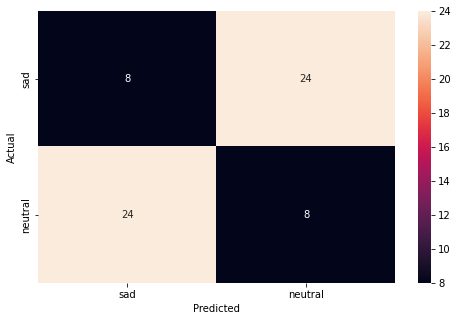

In [ ]:
test_images, test_labels = next(test_set)
pred = binary_model.predict(test_images)
pred = np.argmax(pred, axis = 1) 
y_true = np.argmax(test_labels, axis = 1)
metrics_score_binary(y_true, pred)

And we can see it pretty drastically overfits.

In [ ]:
def build_model():
  model4 = Sequential()
  for i in range(0,11):
    model4.add(binary_model.layers[i])
    model4.layers[i].set_weights(binary_model.layers[i].get_weights())
  model4.add(Flatten())
  for i in range(12,19, 2):
    model4.add(binary_model.layers[i])
    model4.layers[i].set_weights(binary_model.layers[i].get_weights())
    model4.add(Dropout(0.25))
  model4.add(Dense(1,activation = 'sigmoid', name = 'output'))
  model4.trainable = True
  return model4
def build_and_train_model(optimizer, call_backs = None):
    backend.clear_session()
    model = build_model()
    model.compile(loss="binary_crossentropy", optimizer=optimizer,
                  metrics=[keras.metrics.AUC(multi_label = True, 
                                             num_labels = 2
                                             ),"accuracy"]
                  )
    return model.fit(train_set, 
                     epochs=3, 
                     use_multiprocessing=True,
                     validation_data=validation_set,
                     callbacks = call_backs)

### Hyperparameter tuning on binary classification model

In [ ]:
build_and_train_model(keras.optimizers.SGD(learning_rate=0.001))

In [ ]:
history_sgd = build_and_train_model(keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True))

In [ ]:
history_nesterov = build_and_train_model(keras.optimizers.SGD(learning_rate=0.001, 
                                                              momentum=0.9,
                                                              nesterov=True
                                                              ))

In [ ]:
history_adagrad = build_and_train_model(keras.optimizers.Adagrad(learning_rate=0.001))

In [ ]:
history_rmsprop = build_and_train_model(keras.optimizers.RMSprop(learning_rate=0.001, 
                                                                 rho=0.9
                                                                 ))

In [ ]:
history_adam = build_and_train_model(keras.optimizers.Adam())

In [ ]:
history_adamax = build_and_train_model(keras.optimizers.Adamax()) 

In [ ]:
%pip install -q -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.9 MB/s eta 0:00:00


In [ ]:
import tensorflow_addons as tfa

history_adamw = build_and_train_model(tfa.optimizers.AdamW(weight_decay=1e-5, 
                                                           learning_rate=0.001,
                                                           beta_1=0.9, 
                                                           beta_2=0.999
                                                           ))

In [ ]:
history_nadam = build_and_train_model(keras.optimizers.Nadam())

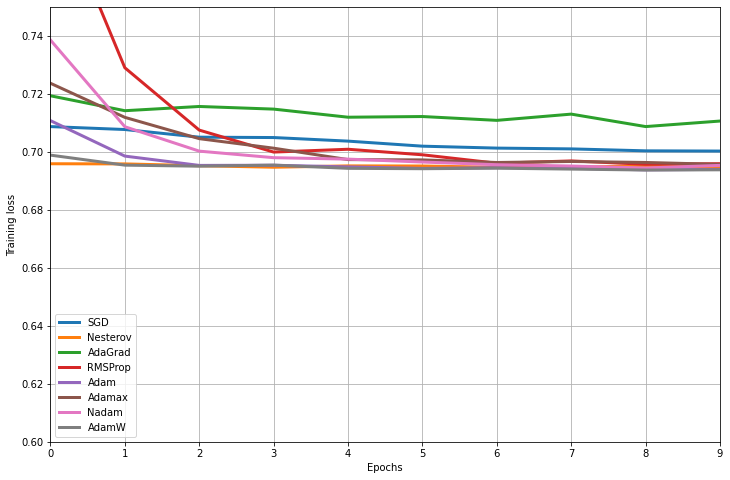

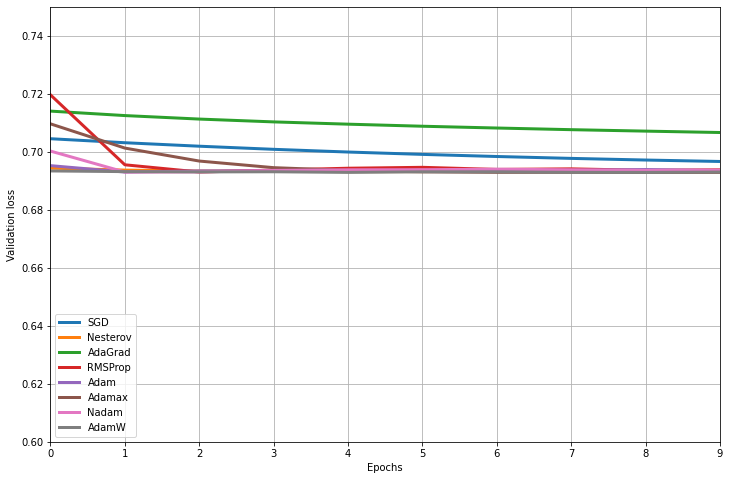

In [ ]:
 # visualize the learning curves of all the optimizers

for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "SGD  Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, 
                                  history_nesterov,
                                  history_adagrad, 
                                  history_rmsprop, 
                                  history_adam,
                                  history_adamax, 
                                  history_nadam, 
                                  history_adamw),
                                  opt_names.split()):
        plt.plot(history.history[loss], 
                 label=f"{opt_name}", 
                 linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", 
                "val_loss": "Validation loss"}[loss])
    plt.legend(loc="lower left")
    plt.axis([0, 
              9, 
              0.6, 
              0.75])
    plt.show()


In [ ]:
history_power_scheduling = build_and_train_model(keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True, decay=1e-4))

In [ ]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.001, s=20)

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

history_exponential_scheduling = build_and_train_model(keras.optimizers.SGD(learning_rate=0.001, 
                                                                            momentum=0.9,
                                                                            nesterov=True), 
                                                       call_backs=[lr_scheduler]
                                                       )

In [ ]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1 ** (1 / 20)

In [ ]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, n_steps=40_000):
        super().__init__()
        self.n_steps = n_steps

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.learning_rate)
        new_learning_rate = lr * 0.1 ** (1 / self.n_steps)
        K.set_value(self.model.optimizer.learning_rate, new_learning_rate)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)

In [ ]:
import math
n_epochs = 5
batch_size = 32
n_steps = n_epochs * math.ceil(7554 / batch_size)
exp_decay = ExponentialDecay(n_steps)
history_iteration_wise_exponential_scheduling = build_and_train_model(keras.optimizers.SGD(learning_rate=0.001, 
                                                                                           momentum=0.9,
                                                                                           nesterov=True
                                                                                           ), 
                                                                      call_backs=[exp_decay]
                                                                      )

In [ ]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # the epoch's mean loss so far 
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.learning_rate,
                    self.model.optimizer.learning_rate * self.factor)

In [ ]:
def find_learning_rate(model, 
                       X, 
                       y, 
                       epochs=1, 
                       batch_size=32, 
                       min_rate=1e-5, 
                       max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, 
                min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, 
                        y, 
                        epochs=epochs, 
                        batch_size=batch_size,
                        callbacks=[
                                  exp_lr
                                  ]
                        )
    K.set_value(model.optimizer.learning_rate, 
                init_lr
                )
    model.set_weights(init_weights
                      )
    return exp_lr.rates, exp_lr.losses

In [ ]:
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, 
             losses, 
             "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), 
               min(rates), 
               max(rates), 
               color="k"
               )
    plt.axis([min(rates), 
              max(rates), 
              min(losses), 
              max_loss]
             )
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

In [ ]:
model = build_model()
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=0.001, 
                                                                         momentum=0.9
                                                                         ,nesterov=True
                                                                         ),
                metrics=[keras.metrics.AUC(multi_label = True
                                           , 
                                           num_labels = 2)
                         ,
                         "accuracy"
                         ]
              )
batch_size = 128
train_images, train_labels = next(train_set_augmented)
rates, losses = find_learning_rate(model, 
                                   train_images, 
                                   train_labels, 
                                   epochs=5,
                                   batch_size=batch_size, 
                                   min_rate=1e-3,
                                   max_rate=.002
                                   )
plot_lr_vs_loss(rates, 
                losses) # This takes some tuning. I ran this block several times to find the optimal value

In [ ]:
history_nesterov = build_and_train_model(keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True))

In [ ]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, 
                 iterations, 
                 max_lr=1e-3, 
                 start_lr=None,
                 last_iterations=None, 
                 last_lr=None
                 ):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, 
                                   self.half_iteration, 
                                   self.start_lr,
                                   self.max_lr
                                   )
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 
                                   2 * self.half_iteration,
                                   self.max_lr, 
                                   self.start_lr
                                   )
        else:
            lr = self._interpolate(2 * self.half_iteration, 
                                   self.iterations,
                                   self.start_lr, 
                                   self.last_lr
                                   )
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, 
                    lr
                    )

In [ ]:
# model = build_model()
# model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
#                                     nesterov=True),
#                 metrics=[keras.metrics.AUC(multi_label = True, num_labels = 2),"accuracy"])
n_epochs = 10
onecycle = OneCycleScheduler(249 * n_epochs,
                             max_lr=1.15e-3
                             ) #.0015 found from minimizing the plot_lr_vs_loss graph
history_1cycle = build_and_train_model(keras.optimizers.SGD(learning_rate=0.001, 
                                                            momentum=0.9,
                                                            nesterov=True
                                                            ), 
                                       call_backs=[onecycle]
                                       )

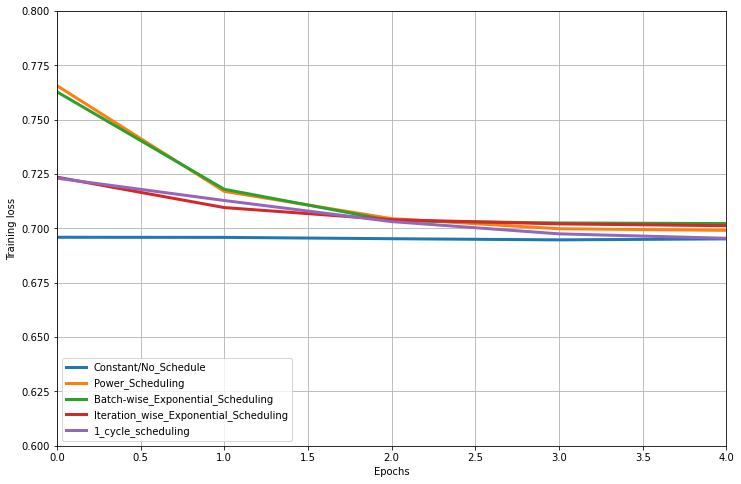

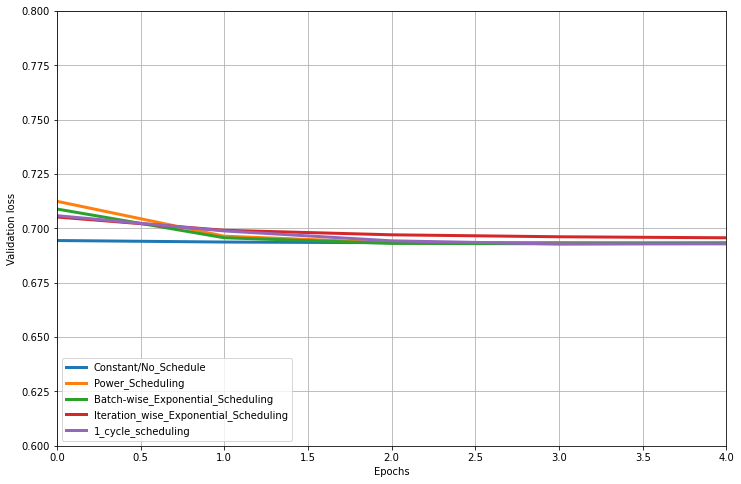

In [ ]:
for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "Constant/No_Schedule Power_Scheduling Batch-wise_Exponential_Scheduling Iteration_wise_Exponential_Scheduling 1_cycle_scheduling"
    for history, opt_name in zip((history_nesterov, 
                                  history_power_scheduling, 
                                  history_exponential_scheduling, 
                                  history_iteration_wise_exponential_scheduling, 
                                  history_1cycle
                                  ),
                                 opt_names.split()):
        plt.plot(history.history[loss], 
                 label=f"{opt_name}", 
                 linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", 
                "val_loss": "Validation loss"
                }[loss])
    plt.legend(loc="lower left")
    plt.axis([0, 4, 0.6, 0.8])
    plt.show()

We can see that even if we try to tune the hyperparameters, we still can't improve upon the base model performance. Therefore, I propose to transpose the problem in a ternary classification problem wherein we distinguish between happy, surprise and sad/neutral. Lets set it up.

## Ternary Classification

In [ ]:
# Storing the path of the data file from the Google drive
path = '/content/drive/MyDrive/ternary.zip'

# The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
picture_size = 48
folder_path = "ternary/"
data_aug = ImageDataGenerator(
                              rotation_range=30, # I don't think we need to care about upside down faces
                              width_shift_range=0.1, 
                              height_shift_range=0.1,
                              horizontal_flip=True,
                              fill_mode='constant', # don't want to introduce new confusing pixels
                              cval = 255 / 2,
                              brightness_range=[0.8,1.2],
                              rescale=1./255
                              )


img_size = 48

train_set_augmented = data_aug.flow_from_directory(folder_path + "train",
                                              target_size = (img_size, img_size),
                                              color_mode = 'grayscale' ,
                                              class_mode = 'categorical',
                                              shuffle = True)
validation_set_augmented = data_aug.flow_from_directory(folder_path + "validation",
                                              target_size = (img_size, img_size),
                                              color_mode = 'grayscale' ,
                                              class_mode = 'categorical',
                                              shuffle = True)


Found 15109 images belonging to 3 classes.
Found 4977 images belonging to 3 classes.


In [ ]:
model_3_128.pop()

In [ ]:
model_3_128.add(Dense(3, activation="softmax", name = "jeff"))

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping, Callback
early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 6,
                          verbose = 1,
                          restore_best_weights = True
                          )


checkpoint = ModelCheckpoint("model1.h5", 
                             monitor = 'val_accuracy',
                             save_weights_only = True, 
                             model = 'max', 
                             verbose = 1)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, cooldown = 2)

In [ ]:
callback = [keras.callbacks.TerminateOnNaN(),
             keras.callbacks.ModelCheckpoint('best_model.h5', 
                                       monitor = 'val_loss',
                                       verbose= 1,
                                       save_best_only = True),
             keras.callbacks.EarlyStopping(min_delta=0.001, 
                                     patience = 5,
                                     verbose = 1,
                                     restore_best_weights = True)
             ]
model_3_128.compile(loss = 'categorical_crossentropy', optimizer='adamax',
                  metrics=[keras.metrics.AUC(multi_label = True, num_labels = 3), 'accuracy', 'Recall', 'Precision'])
history_1 = model_3_128.fit(train_set_augmented, 
                 epochs=5, 
                 use_multiprocessing=True,
                 validation_data=validation_set_augmented,
                 #callbacks = callback
                 )

Epoch 1/100
472/473 [============================>.] - ETA: 0s - loss: 779.7153 - auc_20: 0.4998 - accuracy: 0.3943
Epoch 1: val_loss improved from inf to 1.05103, saving model to best_model.h5
473/473 [==============================] - 27s 53ms/step - loss: 778.0668 - auc_20: 0.4997 - accuracy: 0.3944 - val_loss: 1.0510 - val_auc_20: 0.5000 - val_accuracy: 0.4732
Epoch 2/100
472/473 [============================>.] - ETA: 0s - loss: 83.0097 - auc_20: 0.5019 - accuracy: 0.4283
Epoch 2: val_loss improved from 1.05103 to 1.05017, saving model to best_model.h5
473/473 [==============================] - 24s 49ms/step - loss: 82.8365 - auc_20: 0.5021 - accuracy: 0.4284 - val_loss: 1.0502 - val_auc_20: 0.5000 - val_accuracy: 0.4732
Epoch 3/100
471/473 [============================>.] - ETA: 0s - loss: 1.2409 - auc_20: 0.5040 - accuracy: 0.4337
Epoch 3: val_loss improved from 1.05017 to 1.04536, saving model to best_model.h5
473/473 [==============================] - 24s 51ms/step - loss: 1.2

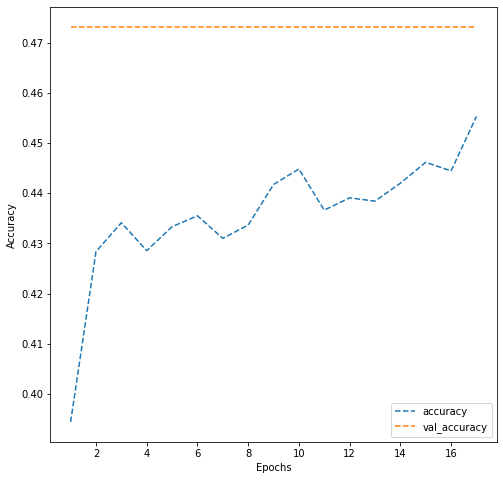

In [ ]:
dict_hist = history_1.history

list_ep = [i for i in range(1, len(dict_hist['accuracy'])+1)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

After several dozen more epochs (omitted for brevity) of training, we acheive excellent metrics on our model:

In [ ]:
model_3_128.compile(loss = 'categorical_crossentropy', optimizer=Adamax(learning_rate=0.001), metrics=[keras.metrics.AUC(multi_label = True, num_labels = 3), 'accuracy', 'Recall', 'Precision'])
backend.clear_session
n_epochs = 15
#onecycle = OneCycleScheduler(473 * n_epochs,
                             #max_lr=0.004)

history_3 = model_3_128.fit(train_set_augmented, epochs=n_epochs,  use_multiprocessing=True,validation_data=validation_set_augmented )

Epoch 1/15
  3/473 [..............................] - ETA: 2:15:45 - loss: 14.7316 - auc_1: 0.5720 - accuracy: 0.4271 - recall: 0.4062 - precision: 0.4333

1/1 [==============================] - 0s 322ms/step - loss: 0.2343 - auc_26: 0.9730 - accuracy: 0.9297
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        32
           1       0.94      0.94      0.94        64
           2       0.94      0.94      0.94        32

    accuracy                           0.93       128
   macro avg       0.93      0.93      0.93       128
weighted avg       0.93      0.93      0.93       128



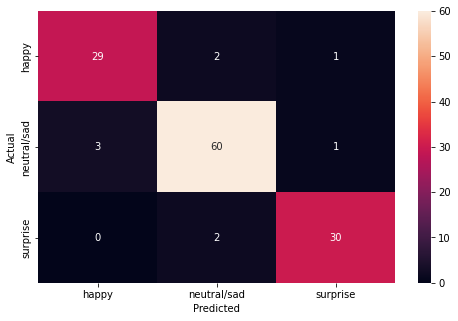

In [ ]:
evaluate_on_testset(model_3_128)

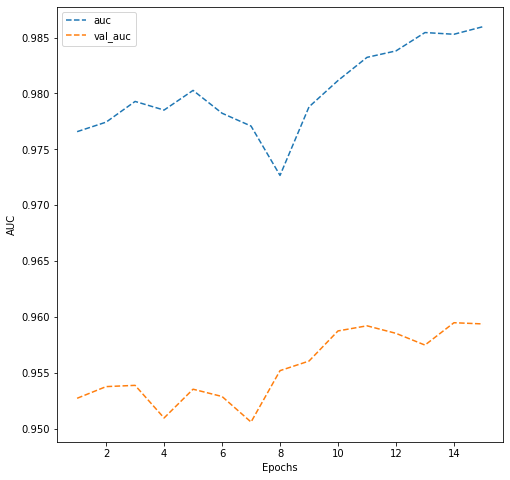

In [ ]:
dict_hist = history_3.history

list_ep = [i for i in range(1, len(dict_hist['accuracy'])+1)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['auc_26'], ls = '--', label = 'auc')

plt.plot(list_ep, dict_hist['val_auc_26'], ls = '--', label = 'val_auc')

plt.ylabel('AUC')

plt.xlabel('Epochs')

plt.legend()

plt.show()

In [ ]:
model_3_128.compile(loss = 'categorical_crossentropy', optimizer=Adamax(learning_rate=0.001),
                  metrics=[keras.metrics.AUC(multi_label = True, num_labels = 3), 'accuracy'])
n_epochs = 10
onecycle = OneCycleScheduler(473 * n_epochs,
                             max_lr=0.01)

history_3 = model_3_128.fit(train_set_augmented, 
                 epochs=n_epochs, 
                 use_multiprocessing=True,
                 validation_data=validation_set_augmented,
                 callbacks = [onecycle, ModelCheckpoint('model_3_128.h5')])

Epoch 1/10
  4/473 [..............................] - ETA: 21s - loss: 0.3208 - auc_27: 0.9730 - accuracy: 0.8906

473/473 [==============================] - 32s 65ms/step - loss: 0.2279 - auc_27: 0.9827 - accuracy: 0.9316 - val_loss: 0.6620 - val_auc_27: 0.9541 - val_accuracy: 0.8718
Epoch 2/10
473/473 [==============================] - 27s 56ms/step - loss: 0.2360 - auc_27: 0.9808 - accuracy: 0.9248 - val_loss: 0.4281 - val_auc_27: 0.9536 - val_accuracy: 0.8732
Epoch 3/10
473/473 [==============================] - 34s 71ms/step - loss: 0.2679 - auc_27: 0.9762 - accuracy: 0.9140 - val_loss: 0.4079 - val_auc_27: 0.9529 - val_accuracy: 0.8684
Epoch 4/10
473/473 [==============================] - 25s 52ms/step - loss: 0.3209 - auc_27: 0.9683 - accuracy: 0.8950 - val_loss: 0.4963 - val_auc_27: 0.9397 - val_accuracy: 0.8389
Epoch 5/10
473/473 [==============================] - 19s 40ms/step - loss: 0.3477 - auc_27: 0.9623 - accuracy: 0.8828 - val_loss: 0.4320 - val_auc_27: 0.9476 - val_accuracy: 0.8435
Epoch 6/10
473/473 [==============================] - 19s 40ms/step - loss: 0.3528 - auc_27: 0.9623 -

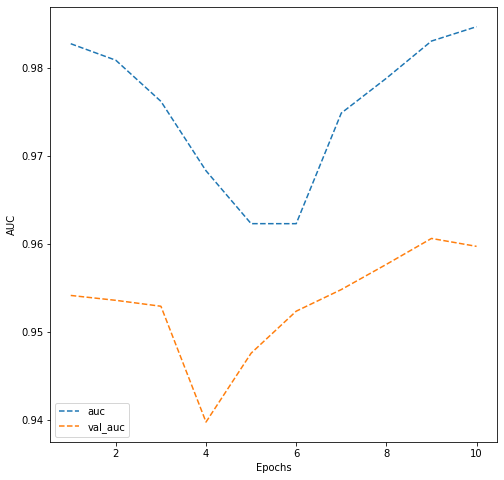

In [ ]:
dict_hist = history_3.history

list_ep = [i for i in range(1, len(dict_hist['accuracy'])+1)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['auc_27'], ls = '--', label = 'auc')

plt.plot(list_ep, dict_hist['val_auc_27'], ls = '--', label = 'val_auc')

plt.ylabel('AUC')

plt.xlabel('Epochs')

plt.legend()

plt.show()

1/1 [==============================] - 0s 90ms/step - loss: 0.2494 - auc_27: 0.9701 - accuracy: 0.9375
              precision    recall  f1-score   support

           0       0.93      0.88      0.90        32
           1       0.94      0.95      0.95        64
           2       0.94      0.97      0.95        32

    accuracy                           0.94       128
   macro avg       0.94      0.93      0.93       128
weighted avg       0.94      0.94      0.94       128



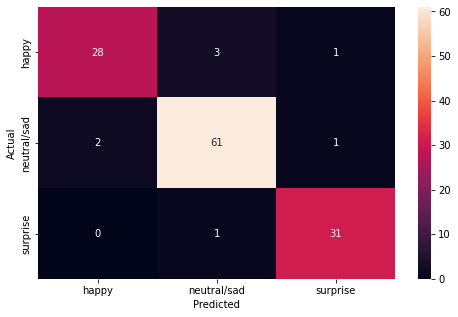

In [ ]:
evaluate_on_testset(model_3_128)

In [ ]:
model_3_128.compile(loss = 'categorical_crossentropy', optimizer=Adamax(learning_rate=0.001),
                  metrics=[keras.metrics.AUC(multi_label = True, num_labels = 3), 'accuracy'])
n_epochs = 20
onecycle = OneCycleScheduler(473 * n_epochs,
                             max_lr=0.01)

history_3 = model_3_128.fit(train_set_augmented, 
                 epochs=n_epochs, 
                 use_multiprocessing=True,
                 validation_data=validation_set_augmented,
                 callbacks = [early_stopping, ModelCheckpoint('model_3_128.h5', verbose = 1)])

Epoch 1/20
473/473 [==============================] - ETA: 0s - loss: 0.2252 - auc_28: 0.9827 - accuracy: 0.9278
Epoch 1: saving model to model_3_128.h5
473/473 [==============================] - 31s 61ms/step - loss: 0.2252 - auc_28: 0.9827 - accuracy: 0.9278 - val_loss: 0.5250 - val_auc_28: 0.9598 - val_accuracy: 0.8792
Epoch 2/20
472/473 [============================>.] - ETA: 0s - loss: 0.2181 - auc_28: 0.9855 - accuracy: 0.9362
Epoch 2: saving model to model_3_128.h5
473/473 [==============================] - 35s 74ms/step - loss: 0.2180 - auc_28: 0.9855 - accuracy: 0.9363 - val_loss: 0.4205 - val_auc_28: 0.9603 - val_accuracy: 0.8762
Epoch 3/20
473/473 [==============================] - ETA: 0s - loss: 0.2002 - auc_28: 0.9857 - accuracy: 0.9336
Epoch 3: saving model to model_3_128.h5
473/473 [==============================] - 29s 59ms/step - loss: 0.2002 - auc_28: 0.9857 - accuracy: 0.9336 - val_loss: 0.4944 - val_auc_28: 0.9577 - val_accuracy: 0.8821
Epoch 4/20
471/473 [========

In [ ]:
model_3_128.compile(loss = 'categorical_crossentropy', optimizer=Adamax(learning_rate=0.0001),
                  metrics=[keras.metrics.AUC(multi_label = True, num_labels = 3), 'accuracy'])
n_epochs = 20
onecycle = OneCycleScheduler(473 * n_epochs,
                             max_lr=0.01)

history_4 = model_3_128.fit(train_set_augmented, 
                 epochs=n_epochs, 
                 use_multiprocessing=True,
                 validation_data=validation_set_augmented,
                 callbacks = [early_stopping, ModelCheckpoint('model_3_128.h5', verbose = 2)])

Epoch 1/20
473/473 [==============================] - ETA: 0s - loss: 0.1985 - auc_29: 0.9864 - accuracy: 0.9352
Epoch 1: saving model to model_3_128.h5
473/473 [==============================] - 36s 69ms/step - loss: 0.1985 - auc_29: 0.9864 - accuracy: 0.9352 - val_loss: 0.4731 - val_auc_29: 0.9582 - val_accuracy: 0.8798
Epoch 2/20
472/473 [============================>.] - ETA: 0s - loss: 0.1989 - auc_29: 0.9855 - accuracy: 0.9341
Epoch 2: saving model to model_3_128.h5
473/473 [==============================] - 26s 53ms/step - loss: 0.1986 - auc_29: 0.9855 - accuracy: 0.9342 - val_loss: 0.5041 - val_auc_29: 0.9569 - val_accuracy: 0.8807
Epoch 3/20
473/473 [==============================] - ETA: 0s - loss: 0.1992 - auc_29: 0.9858 - accuracy: 0.9339
Epoch 3: saving model to model_3_128.h5
473/473 [==============================] - 27s 56ms/step - loss: 0.1992 - auc_29: 0.9858 - accuracy: 0.9339 - val_loss: 0.5298 - val_auc_29: 0.9606 - val_accuracy: 0.8819
Epoch 4/20
473/473 [========

In [ ]:
%%shell
jupyter nbconvert --to html /content/Facial_Emotion_Recognition_3.ipynb

[NbConvertApp] Converting notebook /content/Facial_Emotion_Recognition_3.ipynb to html
[NbConvertApp] Writing 858297 bytes to /content/Facial_Emotion_Recognition_3.html


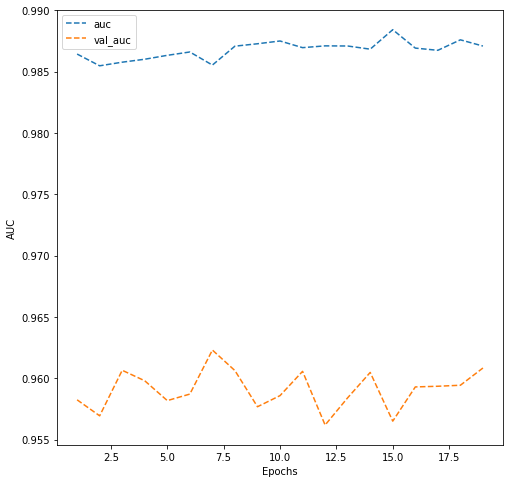

In [ ]:
dict_hist = history_4.history

list_ep = [i for i in range(1, len(dict_hist['accuracy'])+1)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['auc_29'], ls = '--', label = 'auc')

plt.plot(list_ep, dict_hist['val_auc_29'], ls = '--', label = 'val_auc')

plt.ylabel('AUC')

plt.xlabel('Epochs')

plt.legend()

plt.show()

1/1 [==============================] - 0s 95ms/step - loss: 0.2378 - auc_29: 0.9734 - accuracy: 0.9219
              precision    recall  f1-score   support

           0       0.93      0.84      0.89        32
           1       0.91      0.95      0.93        64
           2       0.94      0.94      0.94        32

    accuracy                           0.92       128
   macro avg       0.93      0.91      0.92       128
weighted avg       0.92      0.92      0.92       128



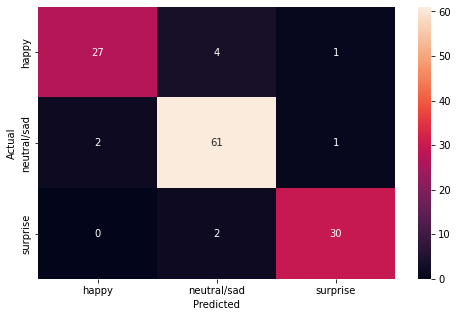

In [ ]:
evaluate_on_testset(model_3_128)

It appears we've reached a ceiling on performance, barring many, many more epochs and further fine tuning (which will certainly happen, eventually), I believe this is it. 

In [ ]:
datagen_test = ImageDataGenerator(rescale=1./255)
folder_path = 'ternary/'
from sklearn.metrics import precision_recall_curve
test_set = datagen_test.flow_from_directory(folder_path + "test",
                                                              target_size = (img_size,img_size),
                                                              color_mode = 'grayscale',
                                                              class_mode = 'categorical',
                                                              classes = ['happy', 'neutral:sad', 'surprise'],
                                                              batch_size=128) 
def evaluate_on_testset(model = None):
  test_images, test_labels = next(test_set)
  if model == None:
    pass
  pred = model.predict(test_images)
  pos_probs = pred[:, 1]
  precision, recall, _ = precision_recall_curve(test_labels, pos_probs)
  pred = np.argmax(pred, axis = 1) 
  y_true = np.argmax(test_labels, axis = 1)
  model.evaluate(test_set)
  metrics_score(y_true, pred)
  auc_score = auc(recall, precision)
  print('Logistic PR AUC: %.3f' % auc_score)

NameError: ignored

In [ ]:
def show_history(old_history=None, new_history = None):
  #hist_df_old = pd.DataFrame(old_history) #I'll at some point make this a little more datatype-agnostic - uncomment or edit to adapt to different datatypes
  #hist_df_new = pd.DataFrame(new_history.history)
  #merged_history = pd.concat((old_history, hist_df_new), axis=0)


  list_ep = [i for i in range(1,old_history.history['accuracy'])]

  plt.figure(figsize = (18, 12))

  # Add a vertical line
  # class_weights_changed_index = 56
  # plt.axvline(x=40, color='k', linestyle='-', label = 'lr schedule changed at epoch 40', lw=.5)
  # plt.axvline(x=60, color='g', linestyle='-', label = 'lr schedule again changed at epoch 60', lw=.5)
  # plt.axvline(x=74, color='y', linestyle='-', label = 'constant lr at 0.005', lw=.5)
  # plt.axvline(x=79, color='r', linestyle='-', label = 'constant lr at 0.007', lw=.5)
  # plt.axvline(x=89, color='r', linestyle='-', label = 'lr schedule modified', lw=.5)





  # Show the plot

  plt.plot(list_ep, merged_history['accuracy'], ls = '--', label = 'accuracy')

  plt.plot(list_ep, merged_history['val_accuracy'], ls = '--', label = 'val_accuracy')

  plt.ylabel('Accuracy')

  plt.xlabel('Epochs')

  plt.legend()

  plt.show()
  return merged_history